In [1]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

In [18]:
main_df = pd.read_csv('./train.csv')
main_test_df = pd.read_csv('./test.csv')

In [19]:
def generate_features(df):
    df['Min Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].min(axis=1)
    df['Max Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].max(axis=1)
    df['CV Length'] = df['Length'] / df['Length'].mean()

    df['Aspect Ratio'] = df['Length'] / df['Diameter']
    df['Shell Weight Ratio'] = df['Shell weight'] / df['Whole weight']
    df['Density'] = df['Whole weight'] / (df['Length'] * df['Diameter'] * df['Height'])  # Assuming cylinder
    df['Density'] = np.where(df['Density'] == np.inf, 0, df['Density'])
    df['Volume'] = np.pi * (df['Diameter'] / 2) ** 2 * df['Height']  # Assuming cylinder
    df['Length to Height Ratio'] = df['Length'] / df['Height']
    df['Length to Height Ratio'] = np.where(df['Length to Height Ratio'] == np.inf, 0, df['Length to Height Ratio'])

    df['Weight Diff Max-Min'] = df['Max Whole Weight'] - df['Min Whole Weight']
    df['Avg Whole Weight'] = (df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2']) / 3
    weight_std = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].std(axis=1)
    df['Std Weight Measures'] = weight_std
    df['CV Whole Weight'] = np.where(weight_std == 0, 0, weight_std / df['Avg Whole Weight'])

    df['Is Male'] = df['Sex'].apply(lambda x: 1 if x == "M" else 0)
    df['Is Female'] = df['Sex'].apply(lambda x: 1 if x == "F" else 0)
    df['Is Infant'] = df['Sex'].apply(lambda x: 1 if x == "I" else 0)
    

    df['Length x Diameter'] = df['Length'] * df['Diameter']
    df['Length x Height'] = df['Length'] * df['Height']
    df['Diameter x Height'] = df['Diameter'] * df['Height']
    df['Length x Shell Weight'] = df['Length'] * df['Shell weight']

    return df

In [20]:
df = generate_features(main_df.copy())
test_df = generate_features(main_test_df.copy())

In [21]:
scaler = MinMaxScaler()
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight',
       'Min Whole Weight', 'Max Whole Weight', 'CV Length', 'Aspect Ratio',
       'Shell Weight Ratio', 'Density', 'Volume', 'Length to Height Ratio',
       'Weight Diff Max-Min', 'Avg Whole Weight', 'Std Weight Measures',
       'CV Whole Weight','Length x Diameter', 'Length x Height', 'Diameter x Height',
       'Length x Shell Weight']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [22]:
train_df, valid_df = train_test_split(df, test_size=0.15, random_state=42)
features = ['Is Male', 'Is Female', 'Is Infant'] + numerical_features
target = ['Rings']

In [23]:
X_train, y_train = train_df[features], train_df[target]
X_valid, y_valid = valid_df[features], valid_df[target]
X_test = test_df[features]

In [24]:
nn_model = Sequential([
    Dense(units=64, activation='relu', input_dim=len(features)),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='relu')
])

In [25]:
def rmsle(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

In [26]:
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 5:
        lr *= 0.07
    return lr

In [27]:
lr_scheduler = LearningRateScheduler(lr_schedule)
nn_model.compile(loss=rmsle)

In [28]:
history = nn_model.fit(X_train, y_train, epochs=8, batch_size=8, validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

Epoch 1/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 402us/step - loss: 0.3722 - val_loss: 0.1630 - learning_rate: 1.0000e-04
Epoch 2/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 394us/step - loss: 0.1568 - val_loss: 0.1487 - learning_rate: 1.0000e-04
Epoch 3/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 402us/step - loss: 0.1475 - val_loss: 0.1474 - learning_rate: 1.0000e-04
Epoch 4/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 399us/step - loss: 0.1463 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 5/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 407us/step - loss: 0.1454 - val_loss: 0.1450 - learning_rate: 1.0000e-04
Epoch 6/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 397us/step - loss: 0.1453 - val_loss: 0.1446 - learning_rate: 1.0000e-04
Epoch 7/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 403us/step - loss: 0.1448 - val_loss: 0.1444 - learning_rate: 7.0000e-06
Epoch 8/8
9628/9628 ━━━━━━━━━━━━━━━━━━━━ 4s 398us/step - loss: 0.1446 - val_loss: 0.1445 - learning_rate: 7.0000e-06


In [29]:
loss_list = history.history['val_loss']

In [30]:
print ('Validation Loss:', loss_list[-1])

Validation Loss: 0.14447546005249023


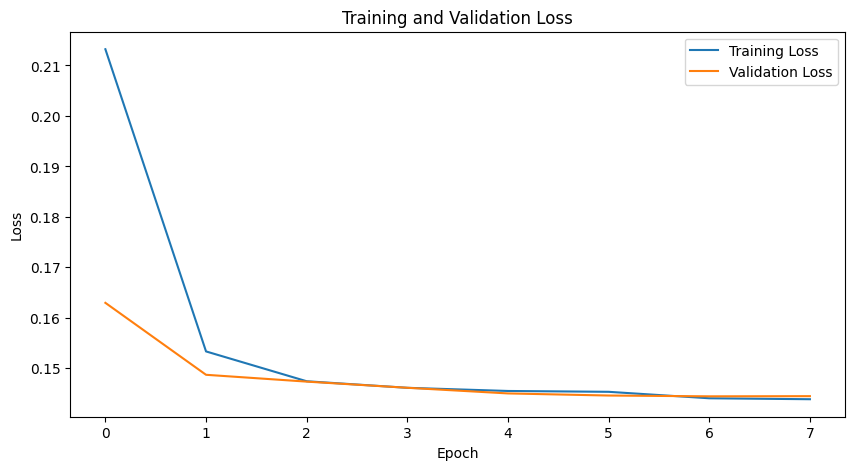

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

y_test = nn_model.predict(X_test)
y_test = np.ceil(y_test)
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['Rings'] = y_test
submission.to_csv('submission.csv', index=False)